In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import operator
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt

/home/zhangxs/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.path.append('/home/zhangxs/soft/xgboost/python-package/')
import xgboost as xgb

In [3]:
def ceate_feature_map(features):  
    outfile = open('xgb.fmap', 'w')  
    i = 0  
    for feat in features:  
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))  
        i = i + 1  
    outfile.close()  

In [4]:
df_train = pd.read_csv("./../quora_pairs/data/new_feature/train_final.csv")
df_train.head(1)

,question1,question2,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,...,q2_when,when_both,q1_why,q2_why,why_both,intersection_count,q1_hash,q2_hash,q1_freq,q2_freq
0,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,66,57,9,20,20,14,12,10,...,0,0,0,0,0,0,0,290457,1,2


In [43]:
scopes = df_train.columns.values[2:]
valid_scopes=[]
for sp in scopes:
    num = df_train[sp].isnull().sum()
    if num==0:
        valid_scopes.append(sp)
print valid_scopes

['len_q1', 'len_q2', 'diff_len', 'len_char_q1', 'len_char_q2', 'len_word_q1', 'len_word_q2', 'common_words', 'fuzz_qratio', 'fuzz_WRatio', 'fuzz_partial_ratio', 'fuzz_partial_token_set_ratio', 'fuzz_partial_token_sort_ratio', 'fuzz_token_set_ratio', 'fuzz_token_sort_ratio', 'wmd', 'norm_wmd', 'cityblock_distance', 'canberra_distance', 'euclidean_distance', 'minkowski_distance', 'skew_q1vec', 'skew_q2vec', 'kur_q1vec', 'kur_q2vec', 'tfidf_word_match', 'shared_count', 'stops1_ratio', 'stops2_ratio', 'shared_2gram', 'words_hamming', 'diff_stops_r', 'len_q1.1', 'len_q2.1', 'diff_len.1', 'caps_count_q1', 'caps_count_q2', 'diff_caps', 'len_char_q1.1', 'len_char_q2.1', 'diff_len_char', 'len_word_q1.1', 'len_word_q2.1', 'diff_len_word', 'avg_world_len1', 'avg_world_len2', 'diff_avg_word', 'exactly_same', 'duplicated', 'q1_how', 'q2_how', 'how_both', 'q1_what', 'q2_what', 'what_both', 'q1_which', 'q2_which', 'which_both', 'q1_who', 'q2_who', 'who_both', 'q1_where', 'q2_where', 'where_both', 'q1

In [44]:
len(valid_scopes)

75

In [45]:
x_train = df_train[valid_scopes].values
print 'train_x.shape',x_train.shape

train_x.shape (404290, 75)


In [6]:
df_train_src = pd.read_csv("./../quora_pairs/data/train.csv")
y_train = df_train_src["is_duplicate"].values
print "train_y",y_train.shape

train_y (404290,)


In [19]:
RS = 1
ROUNDS = 2000

print("Started")
np.random.seed(RS)

Started


In [34]:
def train_xgb(X, y, params):
    print("Will train XGB for {} rounds, RandomSeed: {}".format(ROUNDS, RS))
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.12, random_state=RS)

    xg_train = xgb.DMatrix(x, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    watchlist  = [(xg_train,'train'), (xg_val,'eval')]
    return xgb.train(params, xg_train, ROUNDS, watchlist,early_stopping_rounds=100)

def predict_xgb(clr, X_test):
    return clr.predict(xgb.DMatrix(X_test))

In [48]:
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = ['logloss','error']
params['eta'] = 0.04
params['gpu_id'] = 0
# params['updater'] = 'grow_gpu'
params['nthread']=8
params['min_child_weight']=3
params['max_depth'] = 5
params['subsample']=0.7
params['colsample_bytree']=0.7
params['silent'] = 1
params['seed'] = RS
print("Training")
bst = train_xgb(x_train, y_train, params)

Training
Will train XGB for 2000 rounds, RandomSeed: 1
[0]	train-logloss:0.670438	train-error:0.153299	eval-logloss:0.670408	eval-error:0.153004
Multiple eval metrics have been passed: 'eval-error' will be used for early stopping.

Will train until eval-error hasn't improved in 100 rounds.
[1]	train-logloss:0.653663	train-error:0.149817	eval-logloss:0.653618	eval-error:0.14948
[2]	train-logloss:0.633637	train-error:0.142781	eval-logloss:0.633559	eval-error:0.143997
[3]	train-logloss:0.620805	train-error:0.144594	eval-logloss:0.620667	eval-error:0.143564
[4]	train-logloss:0.603047	train-error:0.140589	eval-logloss:0.602938	eval-error:0.14142
[5]	train-logloss:0.586466	train-error:0.140505	eval-logloss:0.586295	eval-error:0.141008
[6]	train-logloss:0.575214	train-error:0.141502	eval-logloss:0.575003	eval-error:0.141606
[7]	train-logloss:0.564973	train-error:0.141511	eval-logloss:0.564775	eval-error:0.140616
[8]	train-logloss:0.555017	train-error:0.143504	eval-logloss:0.554843	eval-error:

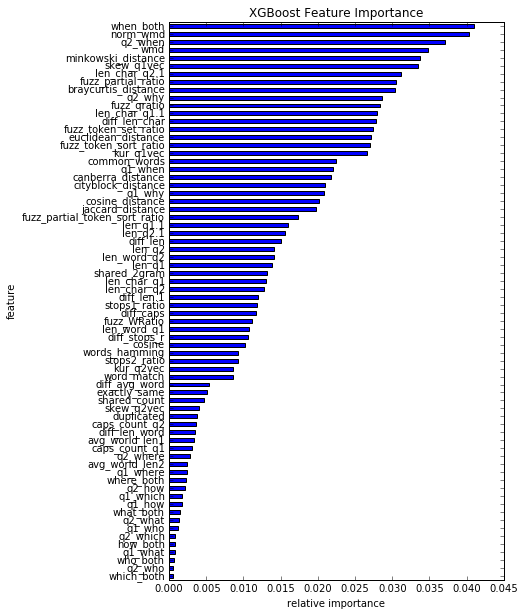

In [47]:
features = [x for x in df_train.columns[2:]]
ceate_feature_map(features)  
  
importance = bst.get_fscore(fmap='xgb.fmap')  
importance = sorted(importance.items(), key=operator.itemgetter(1))  
  
df = pd.DataFrame(importance, columns=['feature', 'fscore'])  
df['fscore'] = df['fscore'] / df['fscore'].sum()  
# df.to_csv("feat_importance.csv", index=False)  
  
plt.figure()  
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))  
plt.title('XGBoost Feature Importance')  
plt.xlabel('relative importance')  

In [15]:
## 删除feature ?
sec = importance[27:]
feat_col = [var[0] for var in sec]
feat_col

['q2_what',
 'q1_what',
 'len_q2.1',
 'stops1_ratio',
 'diff_len.1',
 'stops2_ratio',
 'len_q1.1',
 'caps_count_q2',
 'fuzz_WRatio',
 'diff_len_word',
 'len_char_q2',
 'diff_caps',
 'caps_count_q1',
 'len_q1',
 'len_word_q1',
 'len_char_q1',
 'diff_len',
 'len_q2',
 'diff_len_char',
 'cityblock_distance',
 'len_char_q2.1',
 'len_char_q1.1',
 'braycurtis_distance',
 'len_word_q2',
 'minkowski_distance',
 'fuzz_partial_token_sort_ratio',
 'canberra_distance',
 'q1_freq',
 'cosine_distance',
 'common_words',
 'intersection_count',
 'shared_count',
 'q2_freq',
 'fuzz_token_sort_ratio',
 'fuzz_token_set_ratio',
 'avg_world_len2',
 'skew_q1vec',
 'avg_world_len1',
 'fuzz_partial_ratio',
 'diff_avg_word',
 'fuzz_qratio',
 'skew_q2vec',
 'kur_q2vec',
 'kur_q1vec',
 'wmd',
 'q2_hash',
 'q1_hash',
 'norm_wmd']

## 整一波其他模型试试

## 存储模型

In [28]:
bst.save_model("models/step-394.model")

## For TEST

In [31]:
df_test = pd.read_csv("./../quora_pairs/data/new_feature/test_final.csv")
x_test = df_test.values
x_test = x_test[:,2:]
print(x_test.shape)
df_test_src = pd.read_csv("./../quora_pairs/data/test.csv")

(2345796, 81)


In [32]:
preds = predict_xgb(bst, x_test)
print preds.shape
preds[:10]

(2345796,)


array([  1.59747584e-03,   6.86246529e-02,   1.53856307e-01,
         9.35534248e-04,   2.60524675e-02,   1.71676988e-03,
         9.96071458e-01,   6.02557920e-02,   4.14772600e-01,
         8.96198675e-03], dtype=float32)

In [33]:
print("Writing output...")
sub = pd.DataFrame()
sub['test_id'] = df_test_src['test_id']
sub['is_duplicate'] = preds *.75
sub.to_csv("xgb_mag_feature_rd2000.csv", index=False)

Writing output...
